<a href="https://colab.research.google.com/github/ejnunn/GAN_Research/blob/main/notebooks/AFID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !rm -r GAN_Research
!git clone --quiet https://github.com/ejnunn/GAN_Research.git
!pip install torchextractor

In [3]:
import torch
import torchvision
import torchextractor as tx
import multiprocessing
import numpy as np
import cv2
from scipy import linalg
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

# FID Functions

In [4]:
def get_activations(images, batch_size):
    """
    Calculates activations for last pool layer for all iamges
    --
        Images: torch.array shape: (N, 3, 299, 299), dtype: torch.float32
        batch size: batch size used for inception network
    --
    Returns: np array shape: (N, 2048), dtype: np.float32
    """
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)

    num_images = images.shape[0]
    original_model = torchvision.models.inception_v3(pretrained=True)
    inception_network = tx.Extractor(original_model, ['maxpool1', 'maxpool2', 'avgpool'])
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        model_output, features = inception_network(ims)
        act1, act2, act3 = features.values()

        act1 = act1.detach().cpu().numpy().flatten()
        act1 = np.expand_dims(act1, axis=0)
        act2 = act2.detach().cpu().numpy().flatten()
        act2 = np.expand_dims(act2, axis=0)
        act3 = act3.detach().cpu().numpy().squeeze()
        act3 = np.expand_dims(act3, axis=0)
        
        assert act1.shape == (ims.shape[0], 341056), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 341056), act1.shape)
        assert act2.shape == (ims.shape[0], 235200), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 235200), act2.shape)
        assert act3.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), act3.shape)
        
    return act1, act2, act3

In [5]:
def calculate_activation_statistics(images, batch_size):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer 
                of the inception model.
    """
    act1, act2, act3 = get_activations(images, batch_size)
    
    mu1 = np.mean(act1, axis=0)
    mu2 = np.mean(act2, axis=0)
    mu3 = np.mean(act3, axis=0)

    sigma1 = np.cov(act1, rowvar=False)
    sigma2 = np.cov(act2, rowvar=False)
    sigma3 = np.cov(act3, rowvar=False)
    return mu1, mu2, mu3, sigma1, sigma2, sigma3

In [6]:
# Modified from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [7]:
def calculate_fid(images1, images2, use_multiprocessing, batch_size):
    """ Calculate FID between images1 and images2
    Args:
        images1: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        images2: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
        batch size: batch size used for inception network
    Returns:
        FID (scalar)
    """
    images1 = preprocess_images(images1, use_multiprocessing)
    images2 = preprocess_images(images2, use_multiprocessing)
    mu11, mu12, mu13, sigma11, sigma12, sigma13 = calculate_activation_statistics(images1, batch_size)
    mu21, mu22, mu23, sigma21, sigma22, sigma23 = calculate_activation_statistics(images2, batch_size)
    fid1 = calculate_frechet_distance(mu11, sigma11, mu21, sigma21)
    fid2 = calculate_frechet_distance(mu12, sigma12, mu22, sigma22)
    fid3 = calculate_frechet_distance(mu13, sigma13, mu23, sigma23)
    return fid1, fid2, fid3

In [8]:
def preprocess_image(im):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        im: np.array, shape: (H, W, 3), dtype: float32 between 0-1 or np.uint8
    Return:
        im: torch.tensor, shape: (3, 299, 299), dtype: torch.float32 between 0-1
    """
    assert im.shape[2] == 3
    assert len(im.shape) == 3
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    if im.dtype == np.float64:
        im = im.astype(np.float32) / 255
    im = cv2.resize(im, (299, 299))
    im = np.rollaxis(im, axis=2)
    im = torch.from_numpy(im)
    assert im.max() <= 1.0
    assert im.min() >= 0.0
    assert im.dtype == torch.float32
    assert im.shape == (3, 299, 299)

    return im

In [9]:
def preprocess_images(images, use_multiprocessing):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        images: np.array, shape: (N, H, W, 3), dtype: float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
    Return:
        final_images: torch.tensor, shape: (N, 3, 299, 299), dtype: torch.float32 between 0-1
    """
    if use_multiprocessing:
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            jobs = []
            for im in images:
                job = pool.apply_async(preprocess_image, (im,))
                jobs.append(job)
            final_images = torch.zeros(images.shape[0], 3, 299, 299)
            for idx, job in enumerate(jobs):
                im = job.get()
                final_images[idx] = im#job.get()
    else:
        final_images = torch.stack([preprocess_image(im) for im in images], dim=0)
    assert final_images.shape == (images.shape[0], 3, 299, 299)
    assert final_images.max() <= 1.0
    assert final_images.min() >= 0.0
    assert final_images.dtype == torch.float32
    return final_images

In [10]:
def to_cuda(elements):
    """
    Transfers elements to cuda if GPU is available
    Args:
        elements: torch.tensor or torch.nn.module
        --
    Returns:
        elements: same as input on GPU memory, if available
    """
    if torch.cuda.is_available():
        return elements.cuda()
    return elements

# Calc FID

In [11]:
original_model = torchvision.models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


## Example 1 - Random Tensors

In [ ]:
# Example FID calculations using random tensors
# N x H x W x C
images1 = np.random.rand(128,299,299,3)
images2 = np.random.rand(128,299,299,3)

fid_value1, fid_value2, fid_value3 = calculate_fid(images1, images2, use_multiprocessing=False, batch_size=1)
print('fid_value1 =', fid_value1)
print('fid_value2 =', fid_value2)
print('fid_value3 =', fid_value3)

fid_value1 = 0.5179685354325215
fid_value2 = 0.6253861784937835
fid_value3 = 0.0006701047520119158


## Example 2 - Edited Images

In [12]:
def load_img_as_tensor(path, extra_dim=False):
  img = Image.open(path)
  img = np.array(img)
  if extra_dim:
    img = np.expand_dims(img, 0)
  return img

In [21]:
def edited_img_fids(edit_type):
  # Directory of edited images
  root = '/content/drive/MyDrive/GAN_Research/Datasets/WarpedFace/'

  # First image is unedited original
  images = glob.glob(root + '{}/*.jpg'.format(edit_type))

  # Original image
  image1 = load_img_as_tensor(images[0], extra_dim=True)

  # Store FID values for all images
  fid1, fid2, fid3 = [], [], []

  # Calc FID for each edited image compared to original
  for img in images:
    image2 = load_img_as_tensor(img, extra_dim=True)

    fid_value1, fid_value2, fid_value3 = calculate_fid(image1, image2, use_multiprocessing=False, batch_size=1)

    # Store value for later analysis
    fid1.append(fid_value1)
    fid2.append(fid_value2)
    fid3.append(fid_value3)

  return [fid1, fid2, fid3]

In [22]:
# edited_img_FID_plot('s&p')
noise_fids = edited_img_fids('noise')
warp_fids = edited_img_fids('warp')
sp_fids = edited_img_fids('s&p')
blur_fids = edited_img_fids('blur')

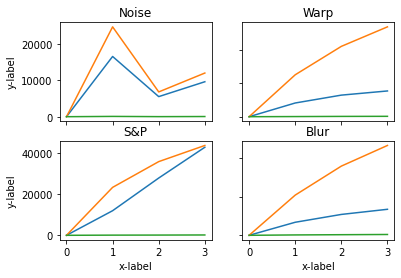

In [26]:
x = [0,1,2,3]
fig, axs = plt.subplots(2, 2)
for i in range(len(noise_fids)):
  axs[0, 0].plot(x, noise_fids[i])
axs[0, 0].set_title('Noise')

for i in range(len(noise_fids)):
  axs[0, 1].plot(x, warp_fids[i])
axs[0, 1].set_title('Warp')

for i in range(len(noise_fids)):
  axs[1, 0].plot(x, sp_fids[i])
axs[1, 0].set_title('S&P')

for i in range(len(noise_fids)):
  axs[1, 1].plot(x, blur_fids[i])
axs[1, 1].set_title('Blur')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


# # Plot FID results
# x = [0,1,2,3]
# plt.plot(x, fid1, label='FID 1')
# plt.plot(x, fid2, label='FID 2')
# plt.plot(x, fid3, label='FID 3')
# plt.xlabel('Degree of editing')
# plt.xticks(x)
# plt.ylabel('FID')
# plt.title('{} image FID scores'.format(edit_type))
# plt.legend()
# plt.show()

## Example 3 - Directory of images

In [20]:
def img_dir_to_tensor(root):
  img_tensors = []
  images = glob.glob(root + '/*.jpg')
  for img_file in images:
    img = load_img_as_tensor(img_file, extra_dim=False)
    img_tensors.append(img.shape)
  stack = torch.stack(img_tensors)
  return stack

path1 = '/content/drive/MyDrive/GAN_Research/Datasets/CelebA_Smiles/real_A/'
path2 = '/content/drive/MyDrive/GAN_Research/Datasets/CelebA_Smiles/fake_B/'

print(img_dir_to_tensor(path1))

RuntimeError: ignored

# Random code

In [ ]:
model = tx.Extractor(original_model, ['maxpool1', 'maxpool2', 'avgpool'])
model.eval()
dummy = torch.rand(1, 3, 299, 299)
model_output, features = model(dummy)
feature_shapes = {name: f.shape for name, f in features.items()}
print(feature_shapes)
for name, f in features.items():
  print(name, f.flatten().shape)

{'maxpool1': torch.Size([1, 64, 73, 73]), 'maxpool2': torch.Size([1, 192, 35, 35]), 'avgpool': torch.Size([1, 2048, 1, 1])}
maxpool1 torch.Size([341056])
maxpool2 torch.Size([235200])
avgpool torch.Size([2048])
